In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re

In [2]:
df = pd.read_csv('request_datasets_staged_v3.csv')

In [3]:
df.head()

,pr_id,description,provenance,request_type,campaign_x,phys_group,project,energy_gev,dataset,input_format,...,data_format,ami_tags,root_taskID,job_creationdate,processingtype,workinggroup,campaign_y,username,request_start,request_end
0,39987,Reco with AF3 - part IV [MC16a],AP,MC,MC20,MCGN,mc20_13TeV,13000,mc20_13TeV:mc20_13TeV.407348.aMcAtNloPythia8Ev...,AOD,...,AOD,e6884_e5984_a899_r13167_r13146,27808083.0,2023-05-09,deriv,GP_TOPQ,mc20_13TeV,atlas-phys-dpd-production,2022-01-11 21:51:54.000000,2023-11-21 10:28:14
1,39987,Reco with AF3 - part IV [MC16a],AP,MC,MC20,MCGN,mc20_13TeV,13000,mc20_13TeV:mc20_13TeV.407348.aMcAtNloPythia8Ev...,AOD,...,AOD,e6884_e5984_a899_r13167_r13146,27808118.0,2023-05-10,deriv,GP_TOPQ,mc20_13TeV,atlas-phys-dpd-production,2022-01-11 21:51:54.000000,2023-11-21 10:28:14
2,39987,Reco with AF3 - part IV [MC16a],AP,MC,MC20,MCGN,mc20_13TeV,13000,mc20_13TeV:mc20_13TeV.407348.aMcAtNloPythia8Ev...,AOD,...,AOD,e6884_e5984_a899_r13167_r13146,27808130.0,2023-05-09,deriv,GP_TOPQ,mc20_13TeV,atlas-phys-dpd-production,2022-01-11 21:51:54.000000,2023-11-21 10:28:14
3,39987,Reco with AF3 - part IV [MC16a],AP,MC,MC20,MCGN,mc20_13TeV,13000,mc20_13TeV:mc20_13TeV.407349.aMcAtNloPythia8Ev...,AOD,...,AOD,e6884_e5984_a899_r13167_r13146,27808242.0,2023-05-10,deriv,GP_TOPQ,mc20_13TeV,atlas-phys-dpd-production,2022-01-11 21:51:54.000000,2023-11-21 10:28:14
4,39987,Reco with AF3 - part IV [MC16a],AP,MC,MC20,MCGN,mc20_13TeV,13000,mc20_13TeV:mc20_13TeV.407349.aMcAtNloPythia8Ev...,AOD,...,AOD,e6884_e5984_a899_r13167_r13146,27808250.0,2023-05-09,deriv,GP_TOPQ,mc20_13TeV,atlas-phys-dpd-production,2022-01-11 21:51:54.000000,2023-11-21 10:28:14


In [31]:
print(df['description'].unique().tolist())

['Reco with AF3 - part IV [MC16a]', 'Data18 period D DAOD_EGAM* production with 22.0.50', 'Data18 period J DAOD_EGAM* production with 22.0.50', 'Data18 period K DAOD_EGAM* production with 22.0.50', 'Data18 period O DAOD_EGAM* production with 22.0.50', 'Data18 period G DAOD_EGAM* production with 22.0.50', 'MC20 Reco - part XV [MC16d]', 'MC20 Reco - part XV [MC16e]', 'Data18 period F DAOD_EGAM* production with 22.0.50', 'Data18 period H DAOD_EGAM* production with 22.0.50', 'Data18 period L DAOD_EGAM* production with 22.0.50', 'Reco with AF3 - part II [mc16a]', 'Data18 period M DAOD_EGAM* production with 22.0.50', 'Data18 period Q DAOD_EGAM* production with 22.0.50', 'Data18 period E DAOD_EGAM* production with 22.0.50', 'Reco with AF3 - part II [MC16d]', 'Reco with AF3 - part III [MC16a]', 'third try: re-reprocessing of (part of) 2018 DataScouting stream ; https://its.cern.ch/jira/browse/DATREP-220', 'third try for ESDs of zero bias data to study the (pile-up) noise thresholds in cluster 

In [32]:
df['description'].value_counts()

description
X->SH->4b Signal MC request: recon                                   222
Derivation production for JETM5 on data22 with 24.0.3                148
semivisible jets s-chan signal grid re-request: MC20 Recon: recon    107
mc20a Excited Quarks for photon+jet with full Run2 (reco)             93
Reprocessing data18 run-2 late stream                                 87
                                                                    ... 
data23 HI reprocessing MinBiasOverlay                                  1
Low-pT tracking sample data17 5TeV (all runs)                          1
Low-pT tracking samples data18 (all runs)                              1
DRAW_ZMUMU data17 reprocessing                                         1
DRAW_ZMUMU reprocessing data15                                         1
Name: count, Length: 155, dtype: int64

In [4]:
# Ensure date columns are in datetime format
df['task_submit_time'] = pd.to_datetime(df['task_submit_time'], errors='coerce')
df['task_end_time'] = pd.to_datetime(df['task_end_time'], errors='coerce')

In [5]:
# Удаляем строки с некорректными датами
df = df.dropna(subset=['task_submit_time', 'task_end_time'])

In [6]:
# Удалим строки, где время конца раньше начала (если такие есть)
df = df[df['task_end_time'] >= df['task_submit_time']]

In [7]:
# Function to normalize description
def group_description(desc):
    if not isinstance(desc, str):
        return "UNKNOWN"
    desc = desc.lower()
    desc = re.sub(r'mc(\d{2})[a-g]', r'MC\1x', desc, flags=re.IGNORECASE) 
    # desc = re.sub(r'data\d{2}', 'dataXX', desc)           # unify data years
    desc = re.sub(r'period [a-z]', 'period X', desc)      # unify period letters
    desc = re.sub(r'\s+', ' ', desc).strip()              # clean whitespace
    return desc

In [8]:
# Apply normalization
df['group'] = df['description'].apply(group_description)

In [9]:
df['group'].nunique()

119

In [10]:
df.head()

,pr_id,description,provenance,request_type,campaign_x,phys_group,project,energy_gev,dataset,input_format,...,ami_tags,root_taskID,job_creationdate,processingtype,workinggroup,campaign_y,username,request_start,request_end,group
0,39987,Reco with AF3 - part IV [MC16a],AP,MC,MC20,MCGN,mc20_13TeV,13000,mc20_13TeV:mc20_13TeV.407348.aMcAtNloPythia8Ev...,AOD,...,e6884_e5984_a899_r13167_r13146,27808083.0,2023-05-09,deriv,GP_TOPQ,mc20_13TeV,atlas-phys-dpd-production,2022-01-11 21:51:54.000000,2023-11-21 10:28:14,reco with af3 - part iv [MC16x]
1,39987,Reco with AF3 - part IV [MC16a],AP,MC,MC20,MCGN,mc20_13TeV,13000,mc20_13TeV:mc20_13TeV.407348.aMcAtNloPythia8Ev...,AOD,...,e6884_e5984_a899_r13167_r13146,27808118.0,2023-05-10,deriv,GP_TOPQ,mc20_13TeV,atlas-phys-dpd-production,2022-01-11 21:51:54.000000,2023-11-21 10:28:14,reco with af3 - part iv [MC16x]
2,39987,Reco with AF3 - part IV [MC16a],AP,MC,MC20,MCGN,mc20_13TeV,13000,mc20_13TeV:mc20_13TeV.407348.aMcAtNloPythia8Ev...,AOD,...,e6884_e5984_a899_r13167_r13146,27808130.0,2023-05-09,deriv,GP_TOPQ,mc20_13TeV,atlas-phys-dpd-production,2022-01-11 21:51:54.000000,2023-11-21 10:28:14,reco with af3 - part iv [MC16x]
3,39987,Reco with AF3 - part IV [MC16a],AP,MC,MC20,MCGN,mc20_13TeV,13000,mc20_13TeV:mc20_13TeV.407349.aMcAtNloPythia8Ev...,AOD,...,e6884_e5984_a899_r13167_r13146,27808242.0,2023-05-10,deriv,GP_TOPQ,mc20_13TeV,atlas-phys-dpd-production,2022-01-11 21:51:54.000000,2023-11-21 10:28:14,reco with af3 - part iv [MC16x]
4,39987,Reco with AF3 - part IV [MC16a],AP,MC,MC20,MCGN,mc20_13TeV,13000,mc20_13TeV:mc20_13TeV.407349.aMcAtNloPythia8Ev...,AOD,...,e6884_e5984_a899_r13167_r13146,27808250.0,2023-05-09,deriv,GP_TOPQ,mc20_13TeV,atlas-phys-dpd-production,2022-01-11 21:51:54.000000,2023-11-21 10:28:14,reco with af3 - part iv [MC16x]


In [11]:
df['task_duration'] = (df['task_end_time'] - df['task_submit_time']).dt.total_seconds() / (24 * 3600)

<Axes: >

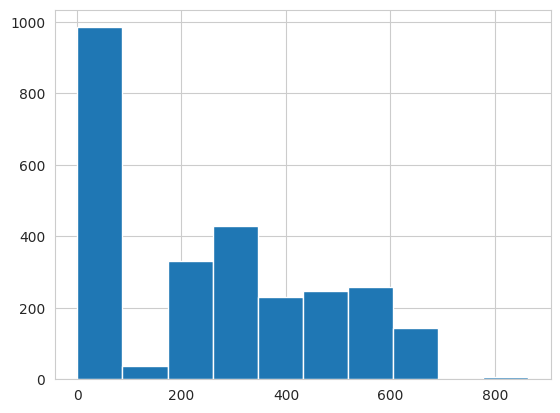

In [12]:
df['task_duration'].hist(bins=10)

<Axes: >

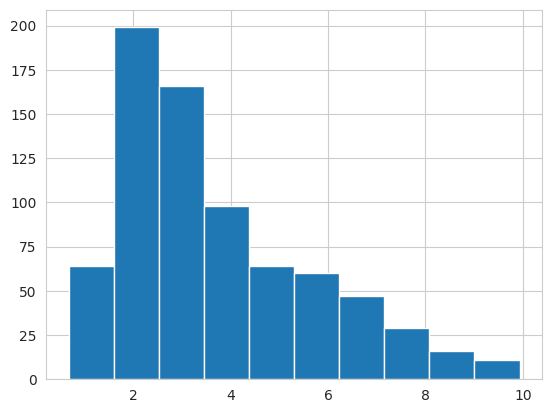

In [59]:
df['task_duration'][df['task_duration']<=10].hist(bins=10)

In [14]:
grouped = df.groupby("group").agg({
    "task_submit_time": "min",
    "task_end_time": "max"
}).reset_index()


In [15]:
grouped.sort_values(by='task_submit_time', ascending=True, inplace=True)

In [16]:
grouped['duration'] = (grouped['task_end_time'] - grouped['task_submit_time']).dt.total_seconds() / (24 * 3600)

In [17]:
grouped['short_group'] = grouped['group'].str[:50]

In [18]:
grouped['duration_td'] = pd.to_timedelta(grouped['duration'], unit='D')


In [79]:
grouped

,group,task_submit_time,task_end_time,duration,short_group,duration_td
21,data18 period X daod_egam* production with 22....,2022-01-02 22:26:07.930200,2022-12-05 22:20:53,336.996355,data18 period X daod_egam* production with 22....,336 days 23:54:45.069799996
62,mc20 reco - part xv [MC16x],2022-01-10 11:03:41.000000,2023-06-26 08:38:39,531.899282,mc20 reco - part xv [MC16x],531 days 21:34:57.999999999
83,reco with af3 - part iv [MC16x],2022-01-11 21:53:36.115898,2023-11-21 10:28:14,678.524050,reco with af3 - part iv [MC16x],678 days 12:34:37.884102
81,reco with af3 - part ii [MC16x],2022-01-24 10:45:57.688548,2023-11-21 10:30:03,665.988950,reco with af3 - part ii [MC16x],665 days 23:44:05.311452001
82,reco with af3 - part iii [MC16x],2022-02-01 13:57:21.000000,2023-11-21 10:20:00,657.849062,reco with af3 - part iii [MC16x],657 days 20:22:38.999999991
...,...,...,...,...,...,...
50,draw_zmumu reprocessing data18,2025-02-11 17:21:04.000000,2025-05-21 12:12:12,98.785509,draw_zmumu reprocessing data18,98 days 18:51:08.000000003
85,reprocessing data16 run-2 late stream,2025-04-03 08:49:07.916751,2025-04-08 23:48:37,5.624642,reprocessing data16 run-2 late stream,5 days 14:59:29.083249
86,reprocessing data17 run-2 late stream,2025-04-03 08:56:12.530569,2025-04-07 13:53:58,4.206776,reprocessing data17 run-2 late stream,4 days 04:57:45.469431
87,reprocessing data18 run-2 late stream,2025-04-03 09:00:15.000000,2025-05-12 20:27:37,39.477338,reprocessing data18 run-2 late stream,39 days 11:27:22.000000003


In [19]:
reprocessing = grouped[grouped['group'].str.contains('repro')]
reco = grouped[grouped['group'].str.contains('reco')]
# deriv_production = grouped[grouped['group'].str.contains('derivation')]
# production = grouped[grouped['group'].str.contains('production')]

In [104]:
reprocessing

,group,task_submit_time,task_end_time,duration,short_group,duration_td
112,third try: re-reprocessing of (part of) 2018 d...,2022-02-09 13:45:16.947715,2022-02-18 22:34:22,9.367420,third try: re-reprocessing of (part of) 2018 d...,9 days 08:49:05.052284996
79,re-reprocessing of (part of) 2018 datascouting...,2022-05-17 13:25:09.000000,2022-07-01 16:29:16,45.127859,re-reprocessing of (part of) 2018 datascouting...,45 days 03:04:07
92,reprocessing of heavy ion data pc stream recor...,2022-06-23 13:56:59.562277,2022-06-27 14:20:05,4.016035,reprocessing of heavy ion data pc stream recor...,4 days 00:23:05.437722998
97,run-3 reprocessing of physics_main in release ...,2022-08-27 17:26:52.000000,2022-09-04 04:18:43,7.452674,run-3 reprocessing of physics_main in release ...,7 days 10:51:50.999999999
109,test minbias reprocessing in r22 with alfa,2023-01-05 09:20:10.000000,2023-04-12 07:40:53,96.931053,test minbias reprocessing in r22 with alfa,96 days 22:20:42.999999996
66,part2: 2017 run2 data reprocessing of the zero...,2023-02-21 13:30:50.707492,2023-02-24 13:30:03,2.999448,part2: 2017 run2 data reprocessing of the zero...,2 days 23:59:12.292507999
95,reproduction of samples from https://its.cern....,2023-03-31 12:40:14.000000,2023-04-03 17:42:39,3.210012,reproduction of samples from https://its.cern....,3 days 05:02:25.000000002
88,reprocessing of 2015 upc stream for https://it...,2023-07-19 09:55:07.000000,2023-08-07 09:21:33,18.976690,reprocessing of 2015 upc stream for https://it...,18 days 23:26:25.999999998
93,reprocessing of run 367134 from 2018 pb+pb in ...,2023-07-26 14:50:09.006933,2023-07-27 08:57:59,0.755440,reprocessing of run 367134 from 2018 pb+pb in ...,0 days 18:07:49.993067003
12,MC23x reprocessing fullsim,2023-12-20 17:09:47.134622,2024-09-12 11:59:39,266.784628,MC23x reprocessing fullsim,266 days 18:49:51.865377997


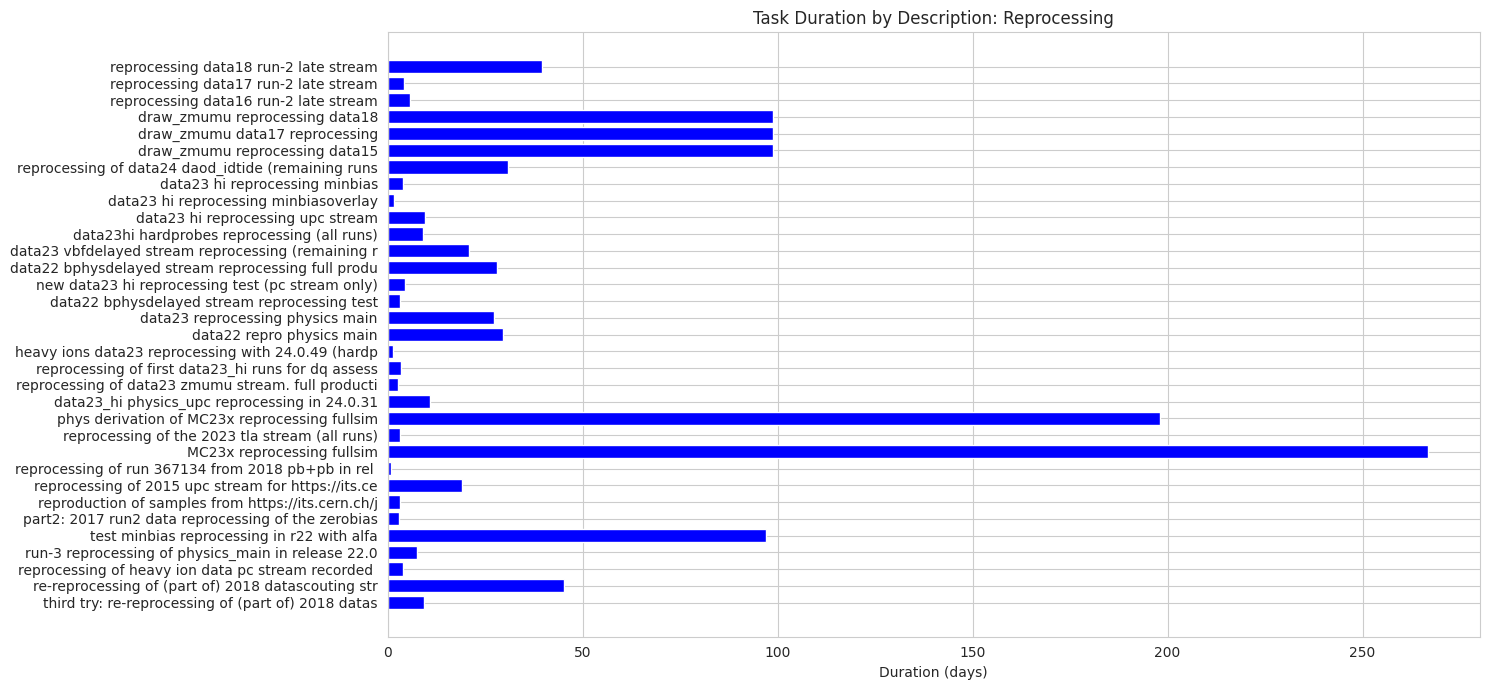

In [105]:
# Plot horizontal bar chart
plt.figure(figsize=(15, 7))
plt.barh(reprocessing['short_group'], reprocessing['duration'], color='blue')
plt.xlabel("Duration (days)")
plt.title("Task Duration by Description: Reprocessing")
plt.tight_layout()
plt.show()

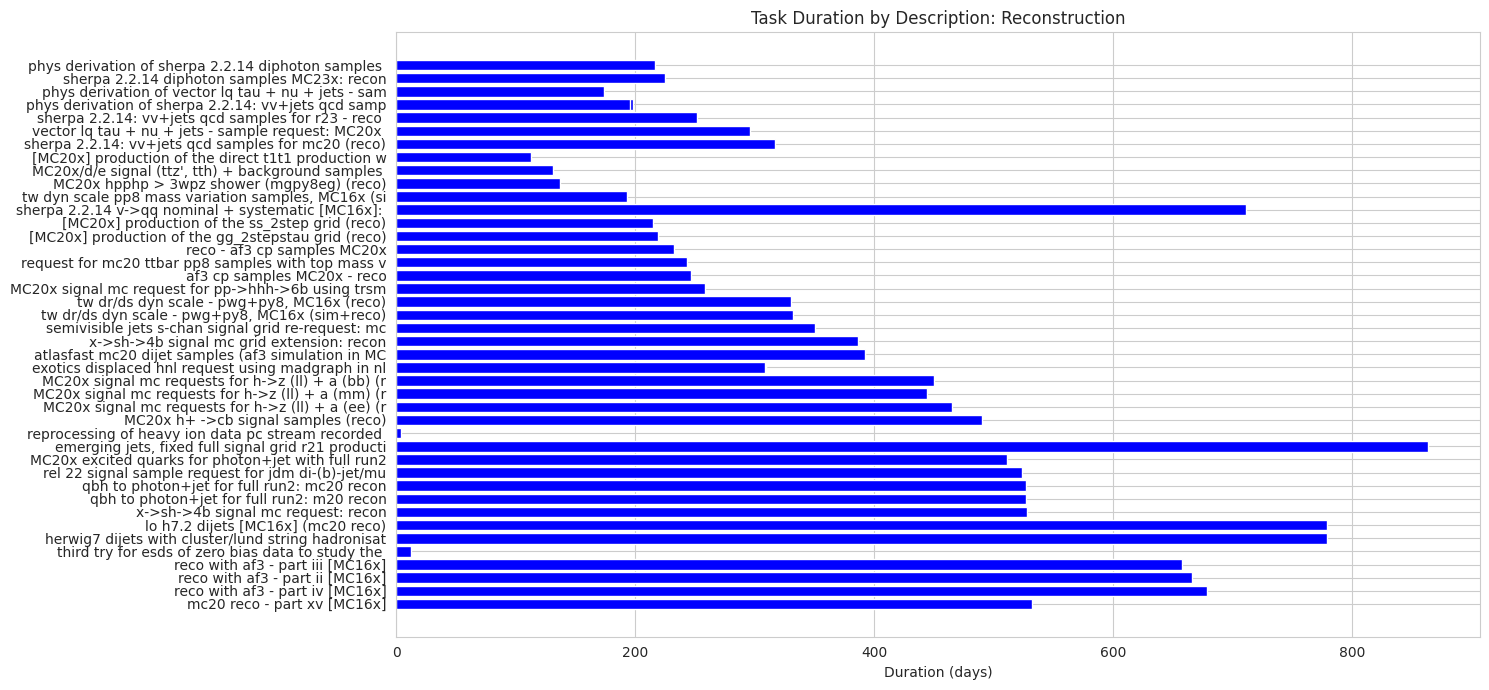

In [106]:
# Plot horizontal bar chart
plt.figure(figsize=(15, 7))
plt.barh(reco['short_group'], reco['duration'], color='blue')
plt.xlabel("Duration (days)")
plt.title("Task Duration by Description: Reconstruction")
plt.tight_layout()
plt.show()

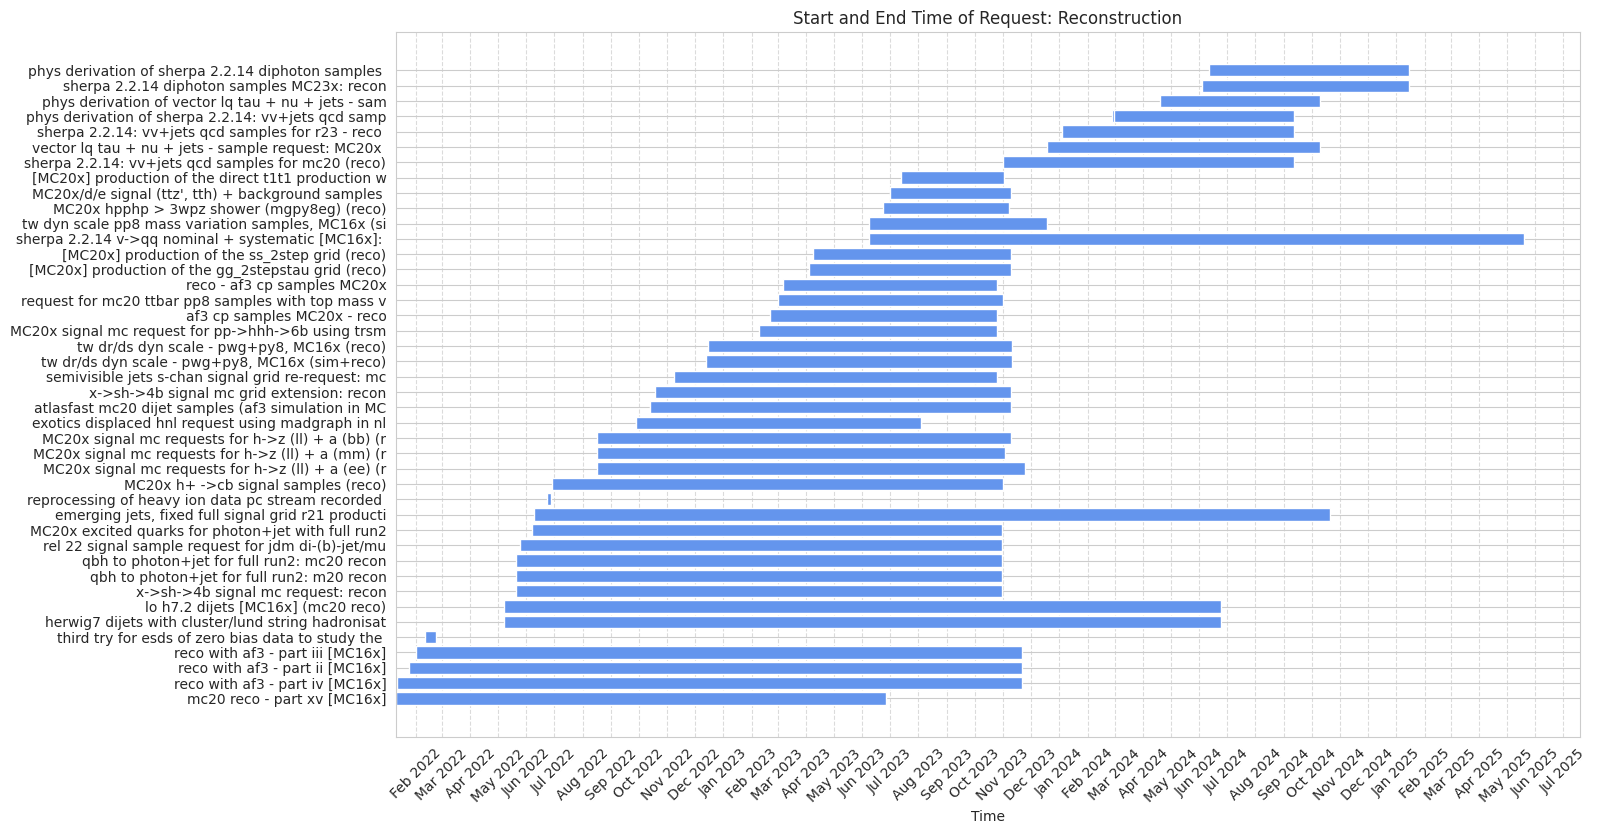

In [20]:
# Plot Gantt-like chart
plt.figure(figsize=(16, 8))
for i, row in reco.iterrows():
    plt.barh(y=row['short_group'],
             left=row['task_submit_time'],
             width=row['duration'],
             color='cornflowerblue')

# Format x-axis
plt.xlabel('Time')
plt.title('Start and End Time of Request: Reconstruction')
plt.tight_layout()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

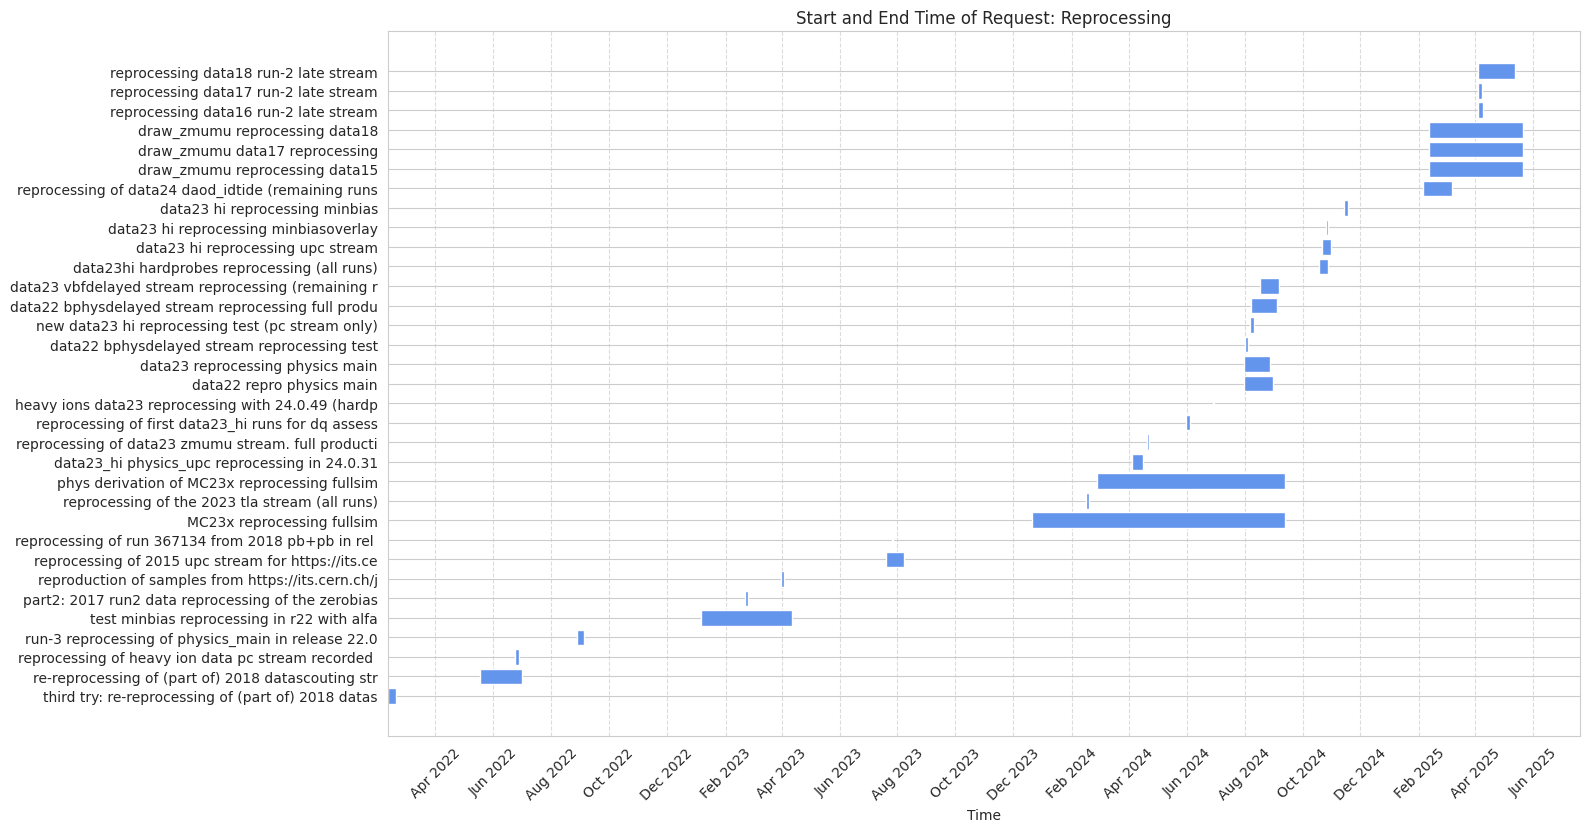

In [21]:
plt.figure(figsize=(16, 8)) 

for i, row in reprocessing.iterrows():
    plt.barh(
        y=row['short_group'],
        left=row['task_submit_time'],
        width=row['duration_td'],
        color='cornflowerblue'
    )

plt.xlabel('Time')
plt.title('Start and End Time of Request: Reprocessing')
plt.tight_layout()

# Настройки оси времени
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()